In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import snntorch as snn
from snntorch import surrogate, BatchNormTT2d
from snntorch import functional

import tonic

from IPython.display import HTML

import matplotlib.pyplot as plt

import numpy as np


from trainer import *

from deepr import *

from line_profiler import LineProfiler

import pickle

import random


In [3]:
slice_meta_path = "./tmp/DVS_sliced/"

dtype=torch.float
print("Convolutional SNN Trained on DVS Gesture")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=32 #you wanna set this so that the gpu uses all its dedicated memory but not any shared i.e. not swapping to main ram
data_path='./tmp/data/DVS/'
num_classes = 11  # DVS has 10 output classes, one for out of class

frame_time = 10

num_steps = 60 #i.e. the number of frames to feed the SNN

transform1 = tonic.transforms.Compose([tonic.transforms.ToFrame(sensor_size=(128,128,2),n_time_bins=num_steps),lambda x: x.astype(np.float32)]) #for some reason using time_window results in an inconsistent number of frames

train_dvs = tonic.datasets.DVSGesture(data_path,train=True)
test_dvs = tonic.datasets.DVSGesture(data_path,train=False)

#this does improve performance
train_dvs_mem = tonic.MemoryCachedDataset(train_dvs)
test_dvs_mem = tonic.MemoryCachedDataset(test_dvs)

slicer = tonic.slicers.SliceByTime(60*frame_time*1000,59*frame_time*1000,False)
#allow an overlap such that we start a new slice at every possible frame.
 
#NOTE Careful , you will need to regenerate after changing parameters, however without it takes about 30 seconds to generate the slices
#slice our dataset into a samples of frame groups - we do not need an entire sample at once
train_sliced_dvs = tonic.SlicedDataset(train_dvs_mem,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"train/")
test_sliced_dvs = tonic.SlicedDataset(test_dvs_mem,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"test/")

#dont bother using disk cached dataset, it doesnt speed things up
#dont bother changing the overlap window either... 
#yes,dataloading is the slowest part of training

train_sampler = torch.utils.data.RandomSampler(train_sliced_dvs, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(test_sliced_dvs, generator=gtest,replacement=False)

train_loader = DataLoader(train_sliced_dvs,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=train_sampler)
test_loader = DataLoader(test_sliced_dvs,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=test_sampler)

print("Train samples:",len(train_loader))
print("Test samples:",len(test_loader))

Convolutional SNN Trained on DVS Gesture
Using device: cuda
Metadata read from ./tmp/DVS_sliced/train/slice_metadata.h5.
Metadata read from ./tmp/DVS_sliced/test/slice_metadata.h5.
Train samples: 19723
Test samples: 5114


In [3]:
'''
print("training samples: ",len(train_sliced_dvs))
print("testing samples: ",len(test_sliced_dvs))
#if you want to create more samples you can change the overlap

a = next(iter(test_loader))
print(test_dvs.classes[a[1][0]])
print(a[0].shape)
animation = tonic.utils.plot_animation(frames=a[0][0])
display(HTML(animation.to_jshtml()))
'''

'\nprint("training samples: ",len(train_sliced_dvs))\nprint("testing samples: ",len(test_sliced_dvs))\n#if you want to create more samples you can change the overlap\n\na = next(iter(test_loader))\nprint(test_dvs.classes[a[1][0]])\nprint(a[0].shape)\nanimation = tonic.utils.plot_animation(frames=a[0][0])\ndisplay(HTML(animation.to_jshtml()))\n'

In [10]:
################ DVS Gesture Model #############################

# layer parameters

lr=1e-4

spike_grad1 = surrogate.atan()

class Net(nn.Module):
    def __init__(self,connectivity):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        self.layers = nn.ModuleList([
            #nn.MaxPool2d(4),
            nn.Conv2d(2,16,4,stride=4),
            BatchNormTT2d(16,num_steps),
            nn.Conv2d(16,64,3),
            BatchNormTT2d(64,num_steps),
            nn.Conv2d(64,128,3),
            BatchNormTT2d(128,num_steps),
            nn.AvgPool2d(2),
            nn.Conv2d(128,128,3),
            BatchNormTT2d(128,num_steps),
            nn.AvgPool2d(2),
            nn.Linear(4608,256),
            nn.Linear(256,11)

        ])

        # initialize neurons
        self.neurons = nn.ModuleList(
            [snn.Leaky(beta=0.3,threshold=0.3,spike_grad=spike_grad1)] * len(self.layers)
        )

        self.to(device) #yes, this is needed twice

        self.deepr = DeepR(self.layers,lr,[0,2,4,7,10,11],connectivity=connectivity,device=device)

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

    def forward(self,x): #x is input data
        #events should be treated as spikes i.e. already encoded

        # Initialize hidden states
        mem = []
        for i in range(len(self.layers)):
            mem.append(self.neurons[i].init_leaky())
        
        # record spike outputs
        spk_rec = []

        for step in range(num_steps):
            #form inputs
            spk_i = x[:,step]


            for i in range(len(self.layers)):
                if(i==10): #need to flatten from pooling to Linear
                    spk_i = torch.flatten(spk_i,start_dim=1)

                if i in {1,3,5,8}:
                    spk_i = self.layers[i][step](spk_i)
                else:
                    cur_i = self.layers[i](spk_i)
                    spk_i, mem[i] = self.neurons[i](cur_i,mem[i])
                        

            spk_rec.append(spk_i)
            


        return torch.stack(spk_rec, dim=0)
    
###################################################################################



Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 12.30
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 3.12%
----------------
Iteration: 100
Training loss: 1.80
Validation loss: 2.14
Validation accuracy: 55.21%
Training accuracy: 65.62%
----------------
Iteration: 200
Training loss: 1.50
Validation loss: 1.39
Validation accuracy: 52.08%
Training accuracy: 68.75%
----------------
Iteration: 300
Training loss: 1.44
Validation loss: 1.69
Validation accuracy: 60.42%
Training accuracy: 65.62%
----------------
Iteration: 400
Training loss: 0.71
Validation loss: 1.21
Validation accuracy: 66.67%
Training accuracy: 68.75%
----------------
Iteration: 500
Training loss: 0.95
Validation loss: 1.78
Validation accuracy: 59.38%
Training accuracy: 78.12%
----------------
Iteration: 600
Training loss: 1.13
Validation loss: 1.61
Validation accuracy: 64.58%
Training accuracy: 68.75%
----------------
Iteration: 700
Training loss: 0.42
Validation loss: 1.41
Validation accuracy: 73.96%
Training accuracy: 84.

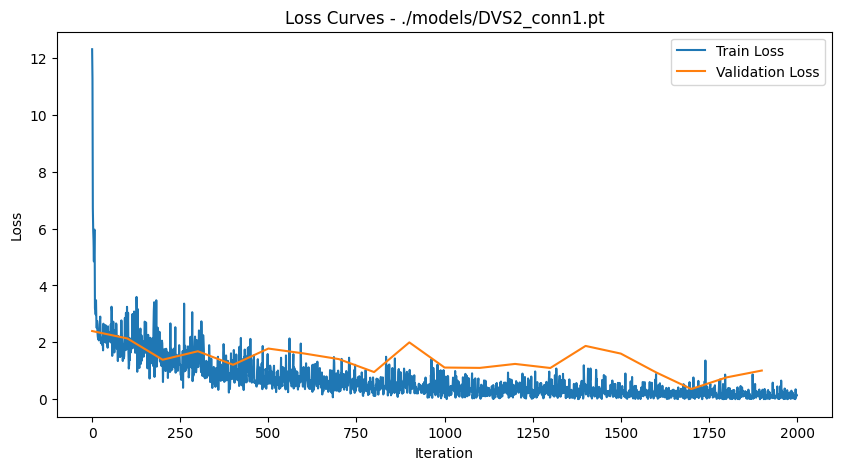

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 83.39%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 9.17
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 0.95
Validation loss: 1.70
Validation accuracy: 56.25%
Training accuracy: 68.75%
----------------
Iteration: 200
Training loss: 1.82
Validation loss: 1.84
Validation accuracy: 56.25%
Training accuracy: 68.75%
----------------
Iteration: 300
Training loss: 0.96
Validation loss: 1.48
Validation accuracy: 61.46%
Training accuracy: 71.88%
----------------
Iteration: 400
Training loss: 0.56
Validation loss: 1.21
Validation accuracy: 61.46%
Training accuracy: 75.00%
----------------
Iteration: 500
Training loss: 0.89
Validation loss: 1.93
Validation accuracy: 59.38%
Training accuracy: 81.25%
----------------
Iteration: 600
Training loss: 0.81
Validation loss: 1.62
Validation accuracy: 63.54%
Training accuracy: 78.12%
----------------
Iteration: 700
Training loss: 0.68
Validation loss: 1.43
Validation accuracy: 68.75%
Training accuracy: 75.0

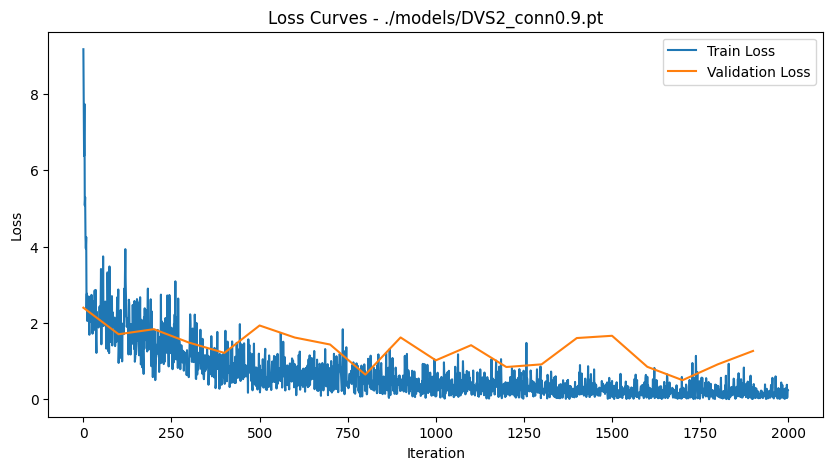

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 83.12%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 8.39
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.26
Validation loss: 1.53
Validation accuracy: 55.21%
Training accuracy: 59.38%
----------------
Iteration: 200
Training loss: 1.51
Validation loss: 2.15
Validation accuracy: 57.29%
Training accuracy: 56.25%
----------------
Iteration: 300
Training loss: 0.97
Validation loss: 1.72
Validation accuracy: 51.04%
Training accuracy: 71.88%
----------------
Iteration: 400
Training loss: 0.49
Validation loss: 1.47
Validation accuracy: 58.33%
Training accuracy: 75.00%
----------------
Iteration: 500
Training loss: 1.00
Validation loss: 1.79
Validation accuracy: 58.33%
Training accuracy: 68.75%
----------------
Iteration: 600
Training loss: 1.20
Validation loss: 2.03
Validation accuracy: 64.58%
Training accuracy: 71.88%
----------------
Iteration: 700
Training loss: 0.44
Validation loss: 1.59
Validation accuracy: 61.46%
Training accuracy: 87.5

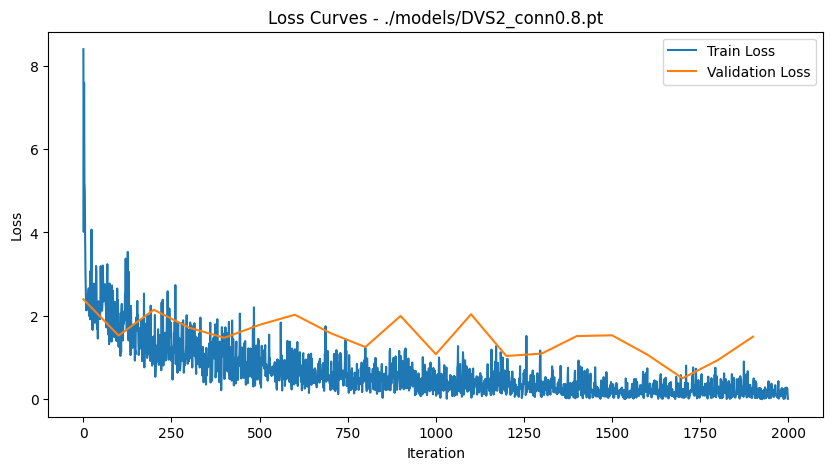

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 81.08%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 4.24
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 18.75%
----------------
Iteration: 100
Training loss: 0.68
Validation loss: 2.17
Validation accuracy: 54.17%
Training accuracy: 68.75%
----------------
Iteration: 200
Training loss: 1.27
Validation loss: 1.67
Validation accuracy: 52.08%
Training accuracy: 68.75%
----------------
Iteration: 300
Training loss: 1.72
Validation loss: 1.86
Validation accuracy: 53.12%
Training accuracy: 59.38%
----------------
Iteration: 400
Training loss: 0.57
Validation loss: 1.54
Validation accuracy: 59.38%
Training accuracy: 84.38%
----------------
Iteration: 500
Training loss: 1.08
Validation loss: 1.68
Validation accuracy: 57.29%
Training accuracy: 78.12%
----------------
Iteration: 600
Training loss: 0.89
Validation loss: 1.55
Validation accuracy: 62.50%
Training accuracy: 65.62%
----------------
Iteration: 700
Training loss: 1.01
Validation loss: 1.79
Validation accuracy: 61.46%
Training accuracy: 71.

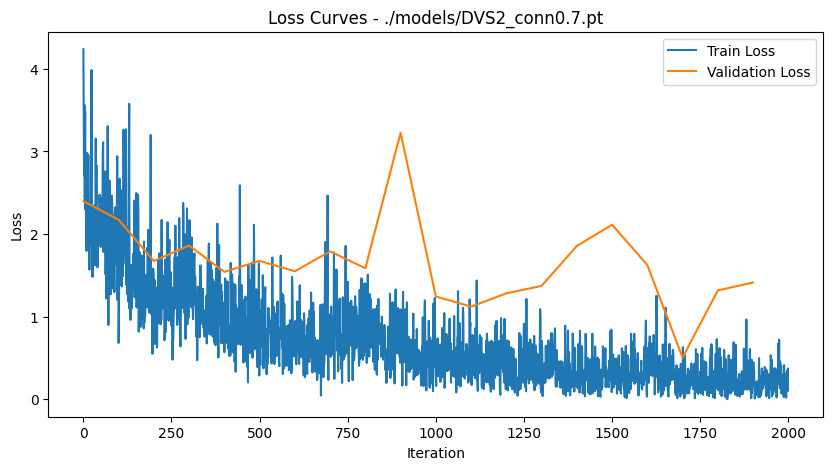

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 80.29%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.35
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 21.88%
----------------
Iteration: 100
Training loss: 1.09
Validation loss: 1.95
Validation accuracy: 55.21%
Training accuracy: 62.50%
----------------
Iteration: 200
Training loss: 1.10
Validation loss: 1.49
Validation accuracy: 63.54%
Training accuracy: 75.00%
----------------
Iteration: 300
Training loss: 1.03
Validation loss: 1.31
Validation accuracy: 57.29%
Training accuracy: 62.50%
----------------
Iteration: 400
Training loss: 0.76
Validation loss: 1.47
Validation accuracy: 60.42%
Training accuracy: 68.75%
----------------
Iteration: 500
Training loss: 0.89
Validation loss: 1.53
Validation accuracy: 53.12%
Training accuracy: 75.00%
----------------
Iteration: 600
Training loss: 1.30
Validation loss: 1.26
Validation accuracy: 66.67%
Training accuracy: 68.75%
----------------
Iteration: 700
Training loss: 0.62
Validation loss: 1.49
Validation accuracy: 65.62%
Training accuracy: 68.

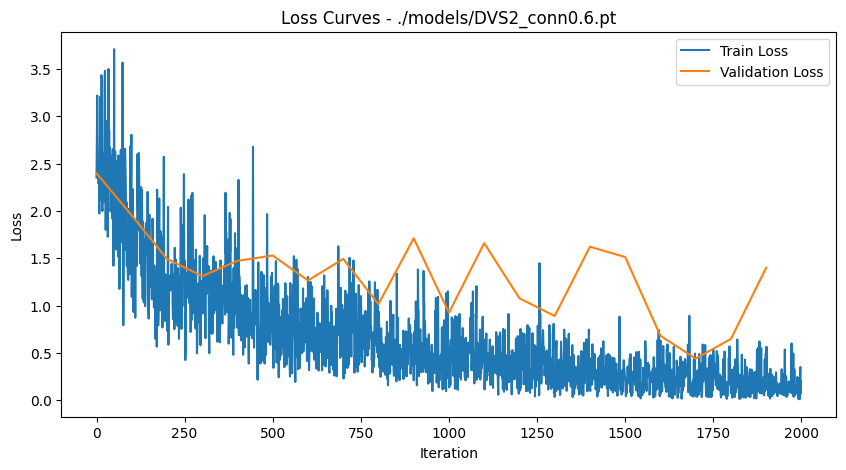

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 80.69%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.53
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 0.97
Validation loss: 1.59
Validation accuracy: 55.21%
Training accuracy: 68.75%
----------------
Iteration: 200
Training loss: 1.34
Validation loss: 2.04
Validation accuracy: 55.21%
Training accuracy: 71.88%
----------------
Iteration: 300
Training loss: 0.56
Validation loss: 1.99
Validation accuracy: 57.29%
Training accuracy: 78.12%
----------------
Iteration: 400
Training loss: 0.26
Validation loss: 1.35
Validation accuracy: 62.50%
Training accuracy: 90.62%
----------------
Iteration: 500
Training loss: 0.89
Validation loss: 2.02
Validation accuracy: 46.88%
Training accuracy: 71.88%
----------------
Iteration: 600
Training loss: 1.52
Validation loss: 1.50
Validation accuracy: 57.29%
Training accuracy: 56.25%
----------------
Iteration: 700
Training loss: 0.57
Validation loss: 1.71
Validation accuracy: 64.58%
Training accuracy: 78.1

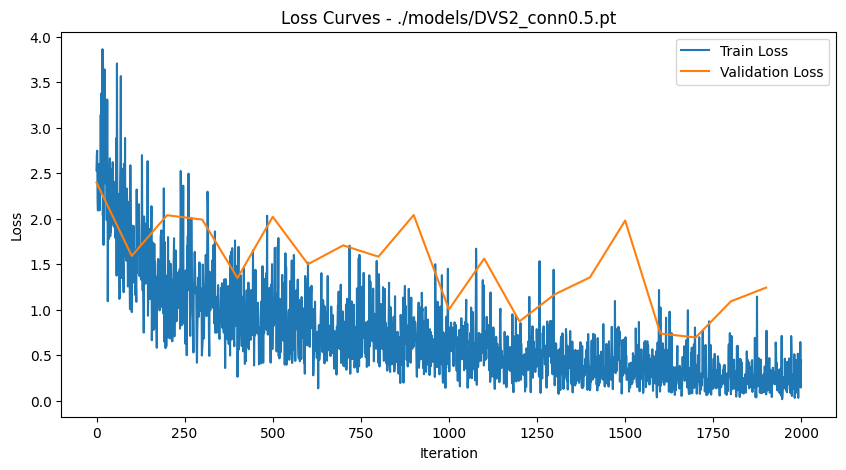

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 78.51%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.37
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 9.38%
----------------
Iteration: 100
Training loss: 1.03
Validation loss: 1.86
Validation accuracy: 53.12%
Training accuracy: 59.38%
----------------
Iteration: 200
Training loss: 1.29
Validation loss: 2.03
Validation accuracy: 51.04%
Training accuracy: 56.25%
----------------
Iteration: 300
Training loss: 1.19
Validation loss: 1.96
Validation accuracy: 59.38%
Training accuracy: 68.75%
----------------
Iteration: 400
Training loss: 0.57
Validation loss: 1.54
Validation accuracy: 61.46%
Training accuracy: 71.88%
----------------
Iteration: 500
Training loss: 0.54
Validation loss: 2.15
Validation accuracy: 54.17%
Training accuracy: 75.00%
----------------
Iteration: 600
Training loss: 1.42
Validation loss: 1.36
Validation accuracy: 58.33%
Training accuracy: 62.50%
----------------
Iteration: 700
Training loss: 1.03
Validation loss: 1.73
Validation accuracy: 60.42%
Training accuracy: 59.3

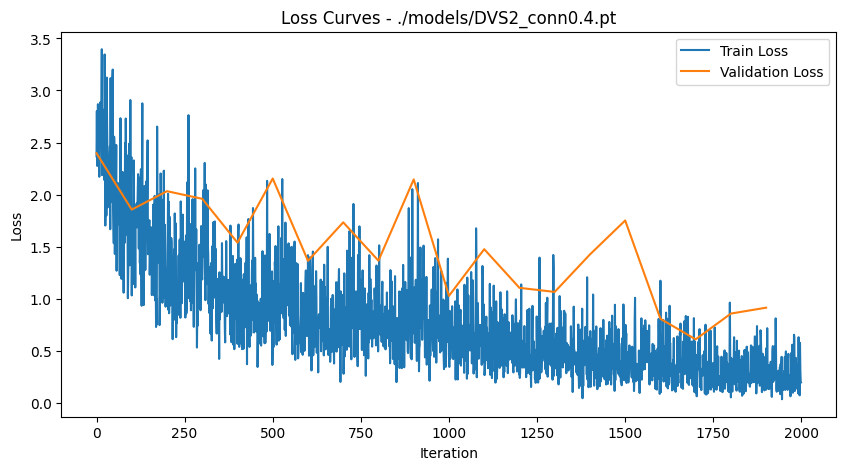

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 77.72%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.18
Validation loss: 2.09
Validation accuracy: 56.25%
Training accuracy: 65.62%
----------------
Iteration: 200
Training loss: 1.26
Validation loss: 1.88
Validation accuracy: 51.04%
Training accuracy: 62.50%
----------------
Iteration: 300
Training loss: 0.97
Validation loss: 2.12
Validation accuracy: 53.12%
Training accuracy: 71.88%
----------------
Iteration: 400
Training loss: 0.89
Validation loss: 1.69
Validation accuracy: 55.21%
Training accuracy: 71.88%
----------------
Iteration: 500
Training loss: 0.54
Validation loss: 2.16
Validation accuracy: 51.04%
Training accuracy: 78.12%
----------------
Iteration: 600
Training loss: 0.58
Validation loss: 1.67
Validation accuracy: 55.21%
Training accuracy: 78.12%
----------------
Iteration: 700
Training loss: 0.83
Validation loss: 1.89
Validation accuracy: 60.42%
Training accuracy: 62.5

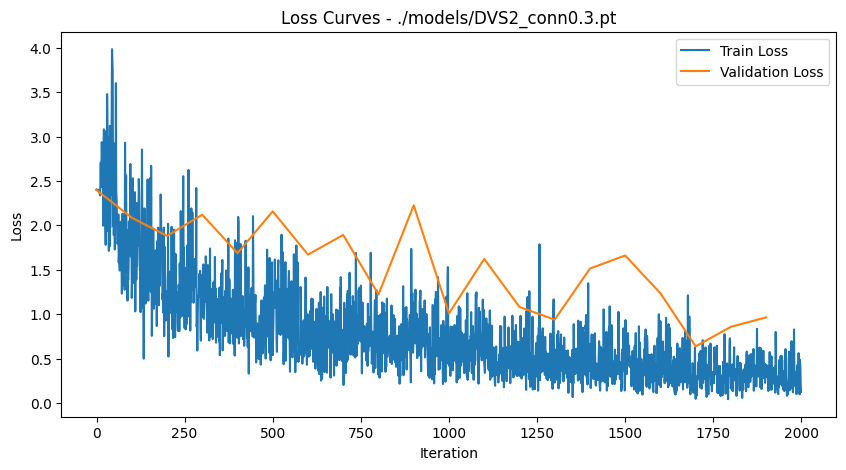

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 77.04%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.36
Validation loss: 1.98
Validation accuracy: 47.92%
Training accuracy: 62.50%
----------------
Iteration: 200
Training loss: 1.64
Validation loss: 1.78
Validation accuracy: 51.04%
Training accuracy: 59.38%
----------------
Iteration: 300
Training loss: 1.08
Validation loss: 2.12
Validation accuracy: 50.00%
Training accuracy: 53.12%
----------------
Iteration: 400
Training loss: 1.37
Validation loss: 1.69
Validation accuracy: 57.29%
Training accuracy: 59.38%
----------------
Iteration: 500
Training loss: 0.92
Validation loss: 1.92
Validation accuracy: 46.88%
Training accuracy: 71.88%
----------------
Iteration: 600
Training loss: 1.28
Validation loss: 1.70
Validation accuracy: 58.33%
Training accuracy: 56.25%
----------------
Iteration: 700
Training loss: 1.01
Validation loss: 1.76
Validation accuracy: 57.29%
Training accuracy: 75.0

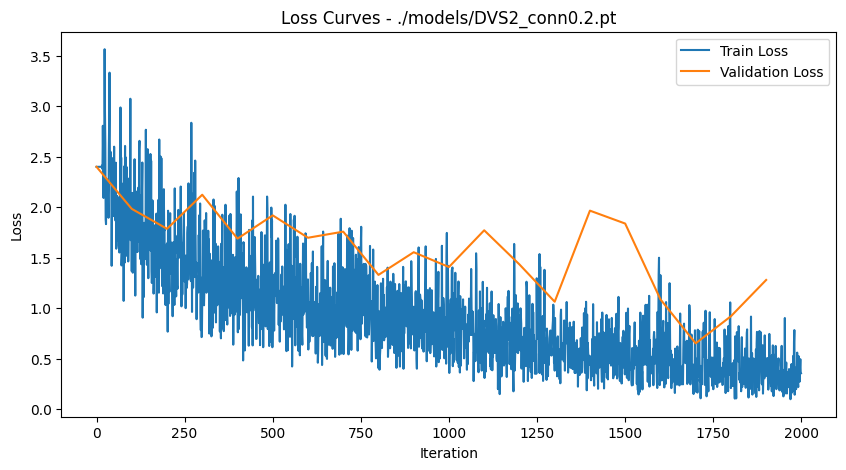

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 75.89%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.18
Validation loss: 2.27
Validation accuracy: 38.54%
Training accuracy: 31.25%
----------------
Iteration: 200
Training loss: 2.04
Validation loss: 1.67
Validation accuracy: 48.96%
Training accuracy: 46.88%
----------------
Iteration: 300
Training loss: 1.16
Validation loss: 1.66
Validation accuracy: 56.25%
Training accuracy: 62.50%
----------------
Iteration: 400
Training loss: 1.10
Validation loss: 1.91
Validation accuracy: 52.08%
Training accuracy: 65.62%
----------------
Iteration: 500
Training loss: 0.97
Validation loss: 2.06
Validation accuracy: 37.50%
Training accuracy: 68.75%
----------------
Iteration: 600
Training loss: 1.20
Validation loss: 1.61
Validation accuracy: 54.17%
Training accuracy: 59.38%
----------------
Iteration: 700
Training loss: 1.23
Validation loss: 1.50
Validation accuracy: 57.29%
Training accuracy: 53.1

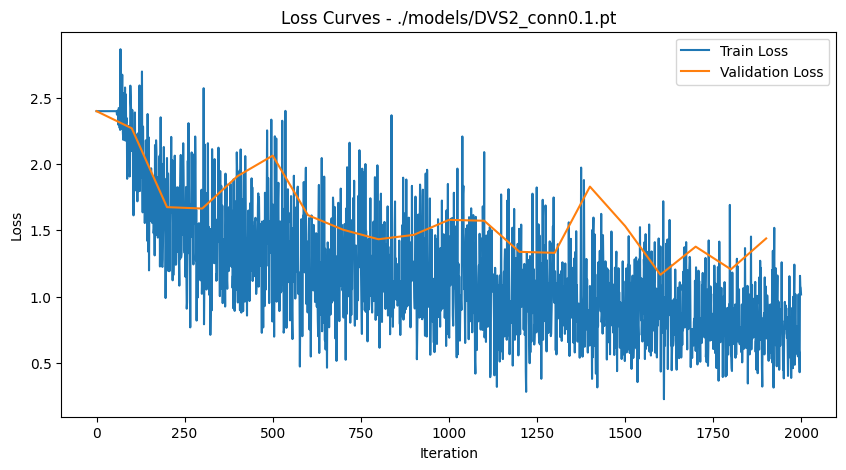

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 63.29%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.27
Validation accuracy: 23.96%
Training accuracy: 9.38%
----------------
Iteration: 200
Training loss: 1.91
Validation loss: 1.90
Validation accuracy: 40.62%
Training accuracy: 46.88%
----------------
Iteration: 300
Training loss: 1.78
Validation loss: 1.91
Validation accuracy: 51.04%
Training accuracy: 43.75%
----------------
Iteration: 400
Training loss: 1.24
Validation loss: 1.78
Validation accuracy: 52.08%
Training accuracy: 65.62%
----------------
Iteration: 500
Training loss: 1.19
Validation loss: 2.50
Validation accuracy: 36.46%
Training accuracy: 50.00%
----------------
Iteration: 600
Training loss: 1.24
Validation loss: 1.72
Validation accuracy: 54.17%
Training accuracy: 65.62%
----------------
Iteration: 700
Training loss: 1.35
Validation loss: 1.83
Validation accuracy: 52.08%
Training accuracy: 50.00

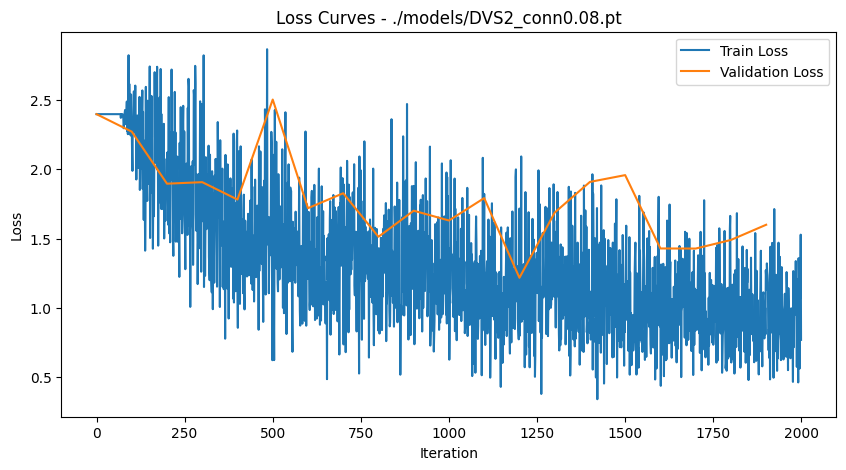

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 57.32%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 14.58%
Training accuracy: 0.00%
----------------
Iteration: 200
Training loss: 2.16
Validation loss: 2.13
Validation accuracy: 28.12%
Training accuracy: 21.88%
----------------
Iteration: 300
Training loss: 1.50
Validation loss: 1.90
Validation accuracy: 47.92%
Training accuracy: 53.12%
----------------
Iteration: 400
Training loss: 1.36
Validation loss: 1.81
Validation accuracy: 51.04%
Training accuracy: 62.50%
----------------
Iteration: 500
Training loss: 1.07
Validation loss: 1.91
Validation accuracy: 36.46%
Training accuracy: 62.50%
----------------
Iteration: 600
Training loss: 1.68
Validation loss: 2.05
Validation accuracy: 50.00%
Training accuracy: 37.50%
----------------
Iteration: 700
Training loss: 1.48
Validation loss: 1.97
Validation accuracy: 41.67%
Training accuracy: 56.25

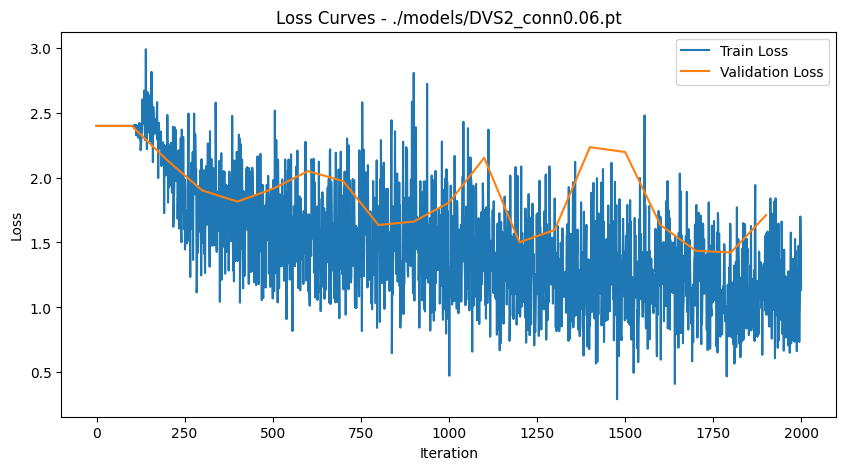

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 54.09%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 14.58%
Training accuracy: 0.00%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 7.29%
Training accuracy: 3.12%
----------------
Iteration: 300
Training loss: 2.17
Validation loss: 2.34
Validation accuracy: 8.33%
Training accuracy: 21.88%
----------------
Iteration: 400
Training loss: 1.36
Validation loss: 1.91
Validation accuracy: 40.62%
Training accuracy: 59.38%
----------------
Iteration: 500
Training loss: 1.57
Validation loss: 2.03
Validation accuracy: 35.42%
Training accuracy: 46.88%
----------------
Iteration: 600
Training loss: 1.78
Validation loss: 2.07
Validation accuracy: 42.71%
Training accuracy: 40.62%
----------------
Iteration: 700
Training loss: 1.81
Validation loss: 1.63
Validation accuracy: 53.12%
Training accuracy: 46.88%
-

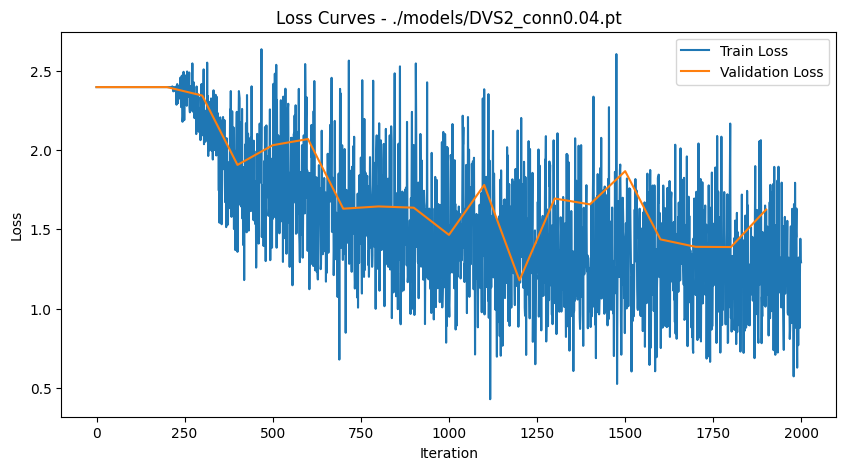

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 50.99%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 14.58%
Training accuracy: 0.00%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 7.29%
Training accuracy: 3.12%
----------------
Iteration: 300
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 4.17%
Training accuracy: 6.25%
----------------
Iteration: 400
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 7.29%
Training accuracy: 9.38%
----------------
Iteration: 500
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 5.21%
Training accuracy: 3.12%
----------------
Iteration: 600
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 7.29%
Training accuracy: 9.38%
----------------
Iteration: 700
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 13.54%
Training accuracy: 0.00%
---------

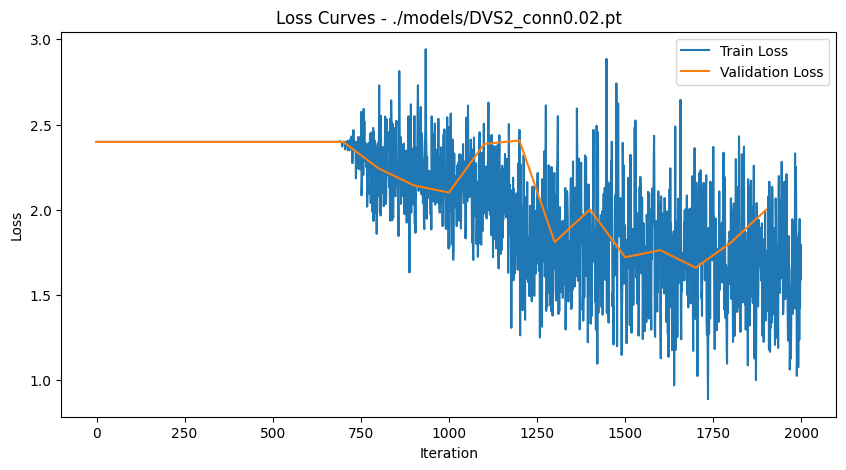

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 44.27%
----


In [5]:
connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.08,0.06,0.04,0.02]

accuracies = []

for c in connectivities:
    model_path = "./models/DVS2_conn"+str(c)+".pt"
    net = Net(c)
    optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
    gen_reset() #reset the PRNG generators for the random samplers so we consistently get the same sequence of samples for each experiment run
    net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=1,iterations=2000,valid_after=100,valid_iterations=3,deepr=True,device=device)
    gen_reset()
    a = test_stats(net,test_loader=test_loader,iterations=500,device=device)
    accuracies.append(a)
    print("----")


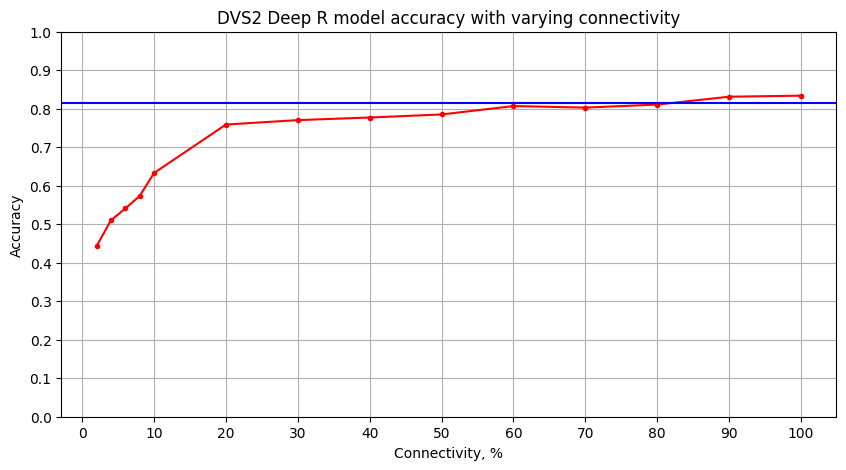

In [8]:
connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.08,0.06,0.04,0.02]


#i forgot to save the accuracies to an array in the main training loop (sorry -_-) 
#these are just the testing accuracies reporting in the cell output above
accuracies = [0.8339,0.8312,0.8108,0.8029,0.8069,0.7851,0.7772,0.7704,0.7589,0.6329,0.5732,0.5409,0.5099,0.4427]
with open("./pickles/DVS2_deepr_accuracies", "wb") as f:
    pickle.dump(accuracies,f)

with open("./pickles/SNN_DVS2_baseline","rb") as f:
    baseline_accuracy = pickle.load(f)

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot([c*100 for c in connectivities],accuracies,'.r-')
plt.title("DVS2 Deep R model accuracy with varying connectivity")
plt.axhline(y = baseline_accuracy, color = 'b', linestyle = '-') #already multiplied by 100 in SNN_DVS_BNTT.ipynb, again i am not rerunning to correct
plt.xlabel("Connectivity, %")
plt.ylabel("Accuracy")
plt.xticks(range(0,101,10))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.show()